In [18]:
import numpy as np

In [19]:
class NBC:
    def __init__(self, feature_types,num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes
    
    def fit(self, Xtrain, ytrain):
        # convert labels to 0,..,K-1,K
        self.u, y_train = np.unique(ytrain, return_inverse=True)            
        self.means = [0] * self.num_classes 
        self.std_devs = [0] * self.num_classes
        self.pi_c = [0] * self.num_classes

        # Calculate mean and standard deviation for each class
        for cls in range(self.num_classes):
            # Filter rows corresponding to the current class
            class_data = Xtrain[y_train == cls]
            # Compute pi_c = N_c/N
            self.pi_c[cls] = np.maximum(class_data.shape[0],1) / Xtrain.shape[0]
            # Compute mean and standard deviation for each column (feature)
            if class_data.shape[0] == 0:
                self.means[cls] = np.zeros((Xtrain.shape[1],))
                self.std_devs[cls] = np.full((Xtrain.shape[1],),1.0e-6)
            else:
                self.means[cls] = np.mean(class_data, axis=0)
                self.std_devs[cls] = np.maximum(np.std(class_data, axis=0),np.full((Xtrain.shape[1],),1.0e-6))
    
    def log_gaussian_pdf(self, x, mean, std):
        return -0.5*np.log(2 * np.pi)-np.log(std) - ((x - mean) ** 2) / (2 * std ** 2)

    def log_bernoulli_pmf(self, x, p):
        if x==1: return np.log(p)
        elif x==0: return np.log(1-p)
    
    def predict(self, Xtest):
        n_samples, n_features = Xtest.shape
        log_probs = np.zeros((n_samples, self.num_classes))

        for c in range(self.num_classes):
            log_prob = np.log(self.pi_c[c])
            for f in range(n_features):
                if self.feature_types[f] == 'r':
                    mean = self.means[c][f]
                    std = self.std_devs[c][f]
                    log_prob += self.log_gaussian_pdf(Xtest[:,f],mean,std)
                elif self.feature_types[f] == 'b':
                    p = self.means[c][f]
                    log_prob += self.log_gaussian_pdf(Xtest[:,f], p)
            log_probs[:,c] = log_prob
        
        # Predict the class with the highest log probability
        return np.argmax(log_probs, axis=1)

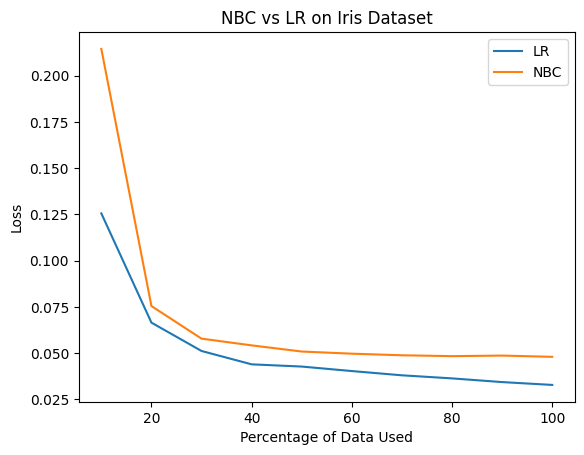

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# C = 1/(lambda)
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']
scaler = StandardScaler()
X = scaler.fit_transform(X)
N, D = X.shape
Ntrain = int(0.8 * N)

scores1 = []
scores2 = []
scores3 = []
for i in range(1000):
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    acc1 = []
    acc2 = []
    acc3 = []
    for j in range(1,11):
        r = int(Ntrain*j/10)
        lr = LogisticRegression(C=10)
        lr.fit(Xtrain[:r],ytrain[:r])
        yhat1 = lr.predict(Xtest)

        nbc = NBC(feature_types=['r', 'r', 'r','r'], num_classes=3)
        nbc.fit(Xtrain[:r],ytrain[:r])
        yhat2 = nbc.predict(Xtest)

        yhat3 = gnb.fit(Xtrain[:r], ytrain[:r]).predict(Xtest)

        acc1.append(np.mean(yhat1 != ytest))
        acc2.append(np.mean(yhat2 != ytest))
        acc3.append(np.mean(yhat3 != ytest))
    scores1.append(acc1)
    scores2.append(acc2)
    scores3.append(acc3)
scores1 = np.mean(scores1,axis=0)
scores2 = np.mean(scores2,axis=0)
scores3 = np.mean(scores3,axis=0)
plt.title("NBC vs LR on Iris Dataset")
plt.ylabel("Loss")
plt.xlabel("Percentage of Data Used")
plt.plot(range(10,110,10), scores1,label = "LR")
plt.plot(range(10,110,10), scores2, label = "NBC")
#plt.plot(range(10,110,10), scores3, label = "NBC sklearn")
plt.legend()

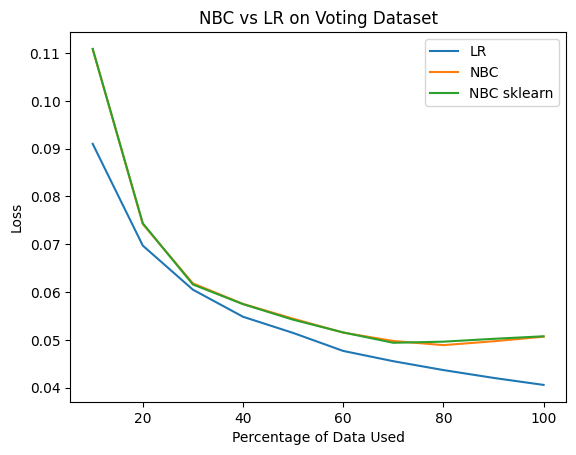

In [ ]:
import pickle as cp
import numpy as np

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

X, y = cp.load(open('voting.pickle', 'rb'))
N, D = X.shape
Ntrain = int(0.8 * N)

scores1 = []
scores2 = []
scores3 = []
for i in range(1000):
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    acc1 = []
    acc2 = []
    acc3 = []
    for j in range(1,11):
        r = int(Ntrain*j/10)
        lr = LogisticRegression()
        lr.fit(Xtrain[:r],ytrain[:r])
        yhat1 = lr.predict(Xtest)

        nbc = NBC(feature_types=['r']*16, num_classes=2)
        nbc.fit(Xtrain[:r],ytrain[:r])
        yhat2 = nbc.predict(Xtest)

        yhat3 = gnb.fit(Xtrain[:r], ytrain[:r]).predict(Xtest)

        acc1.append(np.mean(yhat1 != ytest))
        acc2.append(np.mean(yhat2 != ytest))
        acc3.append(np.mean(yhat3 != ytest))
    scores1.append(acc1)
    scores2.append(acc2)
    scores3.append(acc3)
scores1 = np.mean(scores1,axis=0)
scores2 = np.mean(scores2,axis=0)
scores3 = np.mean(scores3,axis=0)
plt.title("NBC vs LR on Voting Dataset")
plt.ylabel("Loss")
plt.xlabel("Percentage of Data Used")
plt.plot(range(10,110,10), scores1,label = "LR")
plt.plot(range(10,110,10), scores2, label = "NBC")
#plt.plot(range(10,110,10), scores3, label = "NBC sklearn")
plt.legend()